* **Dataset:** MNIST
* **Method:** VAE (Variational AutoEncoder)
* **Tools:** TensorFlow & Keras
* **Purpose:** Generation additional data using the method

# Variational automatic encoder and additional data generation

1. **Introduction**
*  What is autoencoding?
*  Autoencoders
*  The Variational Variety
2. **Data preparation**
*  Load MNIST data
*  Reshape & normalize
*  Plot sample
*  Flatten the images(Last Reshape)
3. **Building VAE model**
*  Sampling Function
*  Encoder network
*  Decoder network
*  Loss function
4. **Train the VAE**
5. **Results**
*  Clustering of digits in the latent space
*  Sample digits

# 1. Introduction

............................


![](https://i.imgur.com/ZN6MyTx.pnghttps://i.imgur.com/ZN6MyTx.png)

**What is autoencoding?**

.............................
....................................
......................................................


**What is VAE?**

...................................
..............................
.......................


**What are the differences between AE and VAE?**

.........................................
.......................................
..................................

# 2. Data preparation

**Importing libraries**

An explanation of each library and version is attached

In [1]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Model # for creating assembling a Neural Network model
from keras import Input # for instantiating a keras tensor and specifying input dimensions
from keras.layers import Dense, Lambda # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from keras import backend as K # for access to Keras backend for reparameterization and creating custom loss function

# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version

# Visualization
import matplotlib.pyplot as plt # for plotting model loss
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version
import plotly
import plotly.express as px # for data visualization
print('plotly: %s' % plotly.__version__) # print version


Tensorflow/Keras: 2.11.0
numpy: 1.21.6
pandas: 1.3.5


NameError: name 'matplotlib' is not defined

**Loading MNIST data**

In the picture you can see samples from the MNIST sample database which contains several thousand handwritten digits. A discriminative model can receive a picture of a digit in a hand, and say what digit it received. On the other hand, a model that seems to learn the distribution of the digits, and a person himself can see new digits like digits he wrote, but in fact they do not appear in the database.
The MNIST database contains 60,000 training images and 10,000 testing images

In [ ]:
# loading data
train_orginal = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_train.csv')
test_orginal = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_test.csv')

# data info
train_orginal.info()
print(train_orginal.shape)
print('-------------------------------------')
test_orginal.info()
print(test_orginal.shape)

**Reshape & normalize**

The data set contains pixels where the value of each pixel ranges from 0 to 255. We will want to normalize the value of each pixel to be between 0 and 1.

In [ ]:
# X's
X_train = train_orginal.drop(['label'], axis = 1)
X_test = test_orginal.drop(['label'], axis = 1)

# labels
y_train = train_orginal['label']
y_test = test_orginal['label']

# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.values.reshape(-1,28,28)

X_test = X_test.astype('float32') / 255.
X_test = X_test.values.reshape(-1,28,28)

# print shape
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Display images of the first 10 digits in the training set and their true lables

In [ ]:
ncols = 5  # number ofcolumns
nrows = 2  #number of rows
fig, axs = plt.subplots(nrows, ncols, sharey=False, tight_layout=True, 
                        figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):                  
    for j in range(0,5):
        axs[i,j].matshow(X_train[n])
        axs[i,j].set(title=y_train[n])
        n=n+1
plt.show() 

**Flatten the images**

The last step in the setup is to flatten the images by reformatting from 28x28 to 784.
Convolutional layers are often used instead of flattening images, especially when working with larger images. But I chose to use dense layers with flat data instead of Convolutional ones.

In [ ]:
# Reshape input data
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

# Print shapes
print("New shape of X_train: ", X_train.shape)
print("New shape of X_test: ", X_test.shape)

# **3. Building VAE model**

**Sampling Function**
Reparameterisation(latent space distribution)
We will start by defining a function that will help us to sample from a latent space distribution Z.
Here we employ a reparameterisation trick that allows the loss to backpropagate through the mean (z-mean) and variance (z-log-sigma) nodes since they are deterministic.
At the same time, we separate the sampling node by adding a non-deterministic parameter, epsilon, which is sampled from a standard Normal distribution.

* Create a function, which we will use to randomly sample from latent space distribution
* Note, epsilon is sampled from a standard normal distribution and is used to maintain the required stochasticity of Z
* Meanwhile, z-mean and z-sigma remain deterministic allowing the loss to backpropagate through the layers.

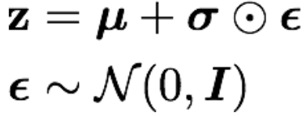

In [ ]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)  # epsilon ~ N(0,1)  -> Gaussian Noise
    return z_mean + K.exp(z_log_sigma) * epsilon     #  latent space -> Z , Z = mean+sigma@epsilon 

**Encoder network**

An encoder that that learns the parameters (mean and variance) of the underlying latent distribution

In [ ]:
# Specify dimensions for input/output and latent space layers
original_dim = 784                                                                    # number of neurons at the input layer(28 * 28 = 784)
latent_dim = 2                                                                        # latent space dimension

# ********** Create Encoder **********

#--- Input Layer 
visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')              # input 

#--- Hidden Layer
h_enc1 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-1')(visible)   # input layer
h_enc2 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)    # first hidden layer  
h_enc3 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)     # second hidden layer

#--- Custom Latent Space Layer
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3)                               # Mean component
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3)                     # Standard deviation component
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma])                  # Z sampling layer -> from sampling func

#--- Create Encoder model
encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')              # Encoder Model

# Display model diagram
plot_model(encoder, show_shapes=True, dpi=70)                                         # Plot layers Diagram

**Decoder network**

A decoder that can turn the sample  back into an image.        
The decoder is basically the encoder in reverse.

In [ ]:
# ********** Create Decoder **********

#--- Input Layer 
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')                        # input = output from latent space

#--- Hidden Layer
h_dec = Dense(units=8, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)    # input layer
h_dec2 = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)          # first hidden layer
h_dec3 = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)         # second hidden layer

#--- Output Layer
outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)   # output layer

#--- Create Decoder model
decoder = Model(latent_inputs, outputs, name='Decoder-Model')                              # Decoder Model

# Display model diagram
plot_model(decoder, show_shapes=True, dpi=70)                                              # Plot layers Diagram

In [ ]:
# Running VAE model
outpt = decoder(encoder(visible)[2]) # outputs available from encoder model are z_mean, z_log_sigma and z. 
                                     # We take z by specifying [2]
    
# Instantiate a VAE model
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*fu-oMTxJRHzRpzwUBBBBcA.png)

**Loss Function**

Before training the VAE model, the final step is to create a custom loss function and compile the model.  
* **KL divergence** - to measure the loss between the latent space distribution and a reference standard Normal distribution
![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRwluYFS3HYg16TpFWyqEW1pjjVDWbwVNtrfVaKq1wMEb5sFu0CuBDDC4e1l7kdpHNhug&usqp=CAUhttps://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRwluYFS3HYg16TpFWyqEW1pjjVDWbwVNtrfVaKq1wMEb5sFu0CuBDDC4e1l7kdpHNhug&usqp=CAU)

* **VAE loss** - 

* **r_loss** - 

In [ ]:
# Reconstruction loss compares inputs and outputs and tries to minimise the difference
r_loss = original_dim * keras.losses.mse(visible, outpt)  # use MSE

# KL divergence loss compares the encoded latent distribution Z with standard Normal distribution and penalizes if it's too different
kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)

# The VAE loss is a combination of reconstruction loss and KL loss
vae_loss = K.mean(r_loss + kl_loss)

# Add loss to the model and compile it
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# 4. **Train the VAE** 

In [ ]:
# Train VAE model
history = vae.fit(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_test, X_test))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=120)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

# 5. Results

**Clustering of digits in the latent space**

In [ ]:
# Use encoder model to encode inputs into a latent space
X_test_encoded = encoder.predict(X_test)

# Recall that our encoder returns 3 arrays: z-mean, z-log-sigma and z. We plot the values for z
# Create a scatter plot
fig = px.scatter(None, x=X_test_encoded[2][:,0], y=X_test_encoded[2][:,1], 
                 opacity=1, color=y_test.astype(str))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

# Set figure title
fig.update_layout(title_text="MNIST digit representation in the 2D Latent Space")

# Update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

Plotting the digit distribution in the latent space gives us the benefit of visually associating different regions with different digits.

Say we want to generate a new image of a digit 3. We know that 3’s are located in the top middle of the latent space. So let’s pick the coordinates of [0, 2.5] and generate an image associated with those inputs.

In [ ]:
# Input latent space coordinates
z_sample_digit=[[0,2.5]]

# Decode latent inputs (i.e., generate new outputs)
digit_decoded = decoder.predict(z_sample_digit)

# Reshape and display the image
plt.matshow(digit_decoded.reshape(28,28))
plt.show()

# 6. Generate new digits 

generate 900 new digits from across the whole latent space.

In [ ]:
# Display a 2D manifold of the digits
n = 30  # figure with 30x30 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# We will sample n points within [-1.5, 1.5] standard deviations
grid_x = np.linspace(1.5, -1.5, n)
grid_y = np.linspace(-1.5, 1.5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # Generate an image using a decoder model
        x_decoded = decoder.predict(z_sample)
        #x_decoded = np.clip(x_decoded, 0.25, 0.75) # we could use cliping to make digit edges thicker
        
        # Reshape from 784 to original digit size (28x28)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Plot figure
plt.figure(figsize=(18, 16))
plt.imshow(figure)
plt.show()

# 7. Reference

**Code:**
1. [Link](http://https://www.tensorflow.org/tutorials/generative/cvae?hl=he)

**Book:**
1. [Link](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438/ref=sr_1_1?ie=UTF8&qid=1520470984&sr=8-1&keywords=francois+chollet)

**GitHub:**
1. [Link](https://github.com/brilliantFire/deep-learning-with-python-notebooks)

**Article**
1. [VAE](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
2. [VAE](https://arxiv.org/pdf/2012.11551.pdf)
3. [Adam Optimization](https://arxiv.org/pdf/1412.6980.pdf)
4. [Relu activation function](https://proceedings.mlr.press/v15/glorot11a/glorot11a.pdf)
